In [1]:
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.markers as markers
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
from datetime import datetime

dotenv_local_path = '.env'
load_dotenv(dotenv_path=dotenv_local_path, verbose=True)

True

## Socrata API

In [7]:
client=Socrata(
"data.cityofnewyork.us",
os.environ.get("NYC_token"),
username=os.environ.get("NYC_username"),
password=os.environ.get("NYC_password")
)

## MySQL

In [8]:
engine = create_engine('mysql+pymysql://' + os.environ.get("MYSQL_USER") + ":" + os.environ.get("MYSQL_PASSWORD") + '@localhost:3306/nyc_crime')

In [9]:
#engine.execute("DROP TABLE IF EXISTS arrests;")

In [10]:
#engine.execute(
"""
CREATE TABLE IF NOT EXISTS arrests (
arrest_key bigint not null primary key,
arrest_date date,
pd_cd int,
pd_desc varchar(250),
ky_cd int,
ofns_desc varchar(250),
law_code varchar(250),
law_cat_cd varchar(250),
arrest_boro varchar(250),
arrest_precinct int,
jurisdiction_code int,
age_group varchar(250),
perp_sex varchar(250),
perp_race varchar(250),
x_coord_cd varchar(250),
y_coord_cd varchar(250),
latitude numeric(15,10),
longitude numeric(15,10)
);
"""
)

In [11]:
start_year=2015
end_year=2019

for i in range(start_year, end_year+1, 1):
    
    results = client.get("8h9b-rp9u", where="arrest_date between "+"'"+str(i)+"-01-01'"+" and "+"'"+str(i)+"-12-31'", limit=10000000)
    results_df = pd.DataFrame.from_records(results)
    
    results_df = results_df.drop('lon_lat',1)

    results_df['arrest_key'] = results_df['arrest_key'].str.strip()
    results_df = results_df.drop(results_df[results_df['arrest_key'] == 'UNKNOWN'].index)
    results_df['arrest_key'] = results_df['arrest_key'].astype(int)
    
    results_df['arrest_date'] = results_df['arrest_date'].str.strip()
    results_df['arrest_date'] = results_df['arrest_date'].astype(str)
    results_df['arrest_date'] = results_df['arrest_date'].str.slice(0,10)
    
    results_df['pd_cd'] = results_df['pd_cd'].str.strip()
    results_df['pd_cd'] = results_df['pd_cd'].str.replace('NULL', '0')
    results_df['pd_cd'] = results_df['pd_cd'].str.replace('UNKNOWN', '0')
    results_df['pd_cd'] = results_df['pd_cd'].fillna('0')
    results_df['pd_cd'] = results_df['pd_cd'].astype(float)
    results_df['pd_cd'] = results_df['pd_cd'].astype(int)
    
    results_df['pd_desc'] = results_df['pd_desc'].str.strip()
    results_df['pd_desc'] = results_df['pd_desc'].str.replace('NULL', 'UNKNOWN')
    results_df['pd_desc'] = results_df['pd_desc'].fillna('UNKNOWN')
    
    results_df['ky_cd'] = results_df['ky_cd'].str.strip()
    results_df['ky_cd'] = results_df['ky_cd'].str.replace('NULL', '0')
    results_df['ky_cd'] = results_df['ky_cd'].fillna('0')
    results_df['ky_cd'] = results_df['ky_cd'].astype(float)
    results_df['ky_cd'] = results_df['ky_cd'].astype(int)  
    
    results_df['ofns_desc'] = results_df['ofns_desc'].str.strip()
    results_df['ofns_desc'] = results_df['ofns_desc'].str.replace('NULL', 'UNKNOWN')
    results_df['ofns_desc'] = results_df['ofns_desc'].fillna('UNKNOWN')
    
    results_df['law_code'] = results_df['law_code'].str.strip()
    results_df['law_code'] = results_df['law_code'].str.replace('NULL', 'UNKNOWN')
    results_df['law_code'] = results_df['law_code'].fillna('UNKNOWN')
    
    results_df['law_cat_cd'] = results_df['law_cat_cd'].str.strip()
    results_df['law_cat_cd'] = results_df['law_cat_cd'].str.replace('NULL', 'UNKNOWN')
    results_df['law_cat_cd'] = results_df['law_cat_cd'].fillna('UNKNOWN')
    
    results_df['arrest_boro'] = results_df['arrest_boro'].str.strip()
    
    results_df['arrest_precinct'] = results_df['arrest_precinct'].str.strip()
    results_df['arrest_precinct'] = results_df['arrest_precinct'].astype(float)
    results_df['arrest_precinct'] = results_df['arrest_precinct'].astype(int)
    
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].str.strip()
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].str.replace('NULL', '0')
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].fillna('0')
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].astype(float)
    results_df['jurisdiction_code'] = results_df['jurisdiction_code'].astype(int)
    
    results_df['age_group'] = results_df['age_group'].str.strip()
    good_ages = ['<18', '18-24', '25-44', '45-64', '65+']
    results_df.loc[~results_df.age_group.isin(good_ages), 'age_group'] = 'UNKNOWN'
    
    results_df['perp_sex'] = results_df['perp_sex'].str.strip()
    results_df['perp_race'] = results_df['perp_race'].str.strip()
    
    results_df['x_coord_cd'] = results_df['x_coord_cd'].str.strip()
    #results_df['x_coord_cd'] = results_df['x_coord_cd'].astype(float)
    #results_df['x_coord_cd'] = results_df['x_coord_cd'].astype(int)
    
    results_df['y_coord_cd'] = results_df['y_coord_cd'].str.strip()
    #results_df['y_coord_cd'] = results_df['y_coord_cd'].astype(float)
    #results_df['y_coord_cd'] = results_df['y_coord_cd'].astype(int)
    
    results_df['latitude'] = results_df['latitude'].str.strip()
    results_df['latitude'] = results_df['latitude'].astype(float)
    
    results_df['longitude'] = results_df['longitude'].str.strip()
    results_df['longitude'] = results_df['longitude'].astype(float)   
    
    results_df.to_sql('arrests_temp', con=engine, index=False, if_exists='replace', chunksize=10000)
    
    engine.execute("""
    UPDATE arrests 
    LEFT JOIN arrests_temp 
    ON arrests.arrest_key = arrests_temp.arrest_key 
    SET arrests.arrest_key = arrests_temp.arrest_key 
    WHERE arrests.arrest_key != arrests_temp.arrest_key;
    """)
    
    engine.execute("""
    INSERT INTO arrests (arrest_key, arrest_date, pd_cd, pd_desc, ky_cd, ofns_desc, law_code, 
    law_cat_cd, arrest_boro, arrest_precinct, jurisdiction_code, age_group, perp_sex, perp_race, 
    x_coord_cd, y_coord_cd, latitude, longitude) 
    SELECT arrest_key, arrest_date, pd_cd, pd_desc, ky_cd, ofns_desc, law_code, law_cat_cd, 
    arrest_boro, arrest_precinct, jurisdiction_code, age_group, perp_sex, perp_race, 
    x_coord_cd, y_coord_cd, latitude, longitude 
    FROM arrests_temp 
    WHERE arrest_key NOT IN (SELECT arrest_key FROM arrests);
    """)
    
    #results_df.to_csv(f"./raw_data/{i}.csv", index=False)

# Data Processing in Python

In [41]:
# Read data from MySQL
df_raw = pd.read_sql("SELECT * FROM arrests", con=engine, parse_dates=["arrest_date"])

In [42]:
# View first 5 frows
df_raw.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
0,140381385,2015-01-01,106,"ASSAULT 2,1,PEACE OFFICER",106,FELONY ASSAULT,PL 1200800,F,M,7,0,18-24,F,WHITE,988225.0,198161.0,40.710590,-73.985664
1,140389276,2015-01-01,117,RECKLESS ENDANGERMENT 1,126,MISCELLANEOUS PENAL LAW,PL 1202500,F,B,49,0,<18,M,WHITE HISPANIC,1026424.0,251705.0,40.857454,-73.847543
2,140389279,2015-01-01,139,"MURDER,UNCLASSIFIED",101,MURDER & NON-NEGL. MANSLAUGHTER,PL 1252501,F,B,40,0,45-64,M,BLACK HISPANIC,1005041.0,234533.0,40.810398,-73.924895
3,140389280,2015-01-01,114,OBSTR BREATH/CIRCUL,344,ASSAULT 3 & RELATED OFFENSES,PL 1211100,M,B,46,0,25-44,M,BLACK,1009339.0,248782.0,40.849497,-73.909316
4,140389281,2015-01-01,904,"INTOXICATED DRIVING,ALCOHOL",119,INTOXICATED/IMPAIRED DRIVING,VTL11920E2,F,B,52,0,25-44,M,WHITE HISPANIC,1008647.0,253247.0,40.861754,-73.911801


In [43]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401949 entries, 0 to 1401948
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   arrest_key         1401949 non-null  int64         
 1   arrest_date        1401949 non-null  datetime64[ns]
 2   pd_cd              1401949 non-null  int64         
 3   pd_desc            1401949 non-null  object        
 4   ky_cd              1401949 non-null  int64         
 5   ofns_desc          1401949 non-null  object        
 6   law_code           1401949 non-null  object        
 7   law_cat_cd         1401949 non-null  object        
 8   arrest_boro        1401949 non-null  object        
 9   arrest_precinct    1401949 non-null  int64         
 10  jurisdiction_code  1401949 non-null  int64         
 11  age_group          1401949 non-null  object        
 12  perp_sex           1401949 non-null  object        
 13  perp_race          1401949 

In [44]:
# Rows and columns
df_raw.shape

(1401949, 18)

In [45]:
# Make copy of df_main so we can leave df_main intact
df = df_raw.copy()

In [46]:
# Drop the rows where at least one element is missing.
df = df.dropna()

In [47]:
# Drop unnecessary columns
df = df.drop(['pd_cd', 'ky_cd', 'law_code', 'jurisdiction_code'], axis=1)

In [48]:
# Rows and columns
df.shape

(1401949, 14)

In [49]:
# Change x_coord_cd and y_coord_cd to integers
df['x_coord_cd'] = df['x_coord_cd'].astype(float)
df['x_coord_cd'] = df['x_coord_cd'].astype(int)
df['y_coord_cd'] = df['y_coord_cd'].astype(float)
df['y_coord_cd'] = df['y_coord_cd'].astype(int)

In [50]:
# Create columns for year, month, date
df['arrest_year'] = df['arrest_date'].dt.year
df['arrest_month'] = df['arrest_date'].dt.month
df['arrest_day'] = df['arrest_date'].dt.day
df['arrest_day_index'] = df['arrest_date'].dt.dayofweek
df['arrest_day_name'] = df['arrest_date'].dt.day_name()

In [51]:
# See unique ofns_desc
df['ofns_desc'].unique()

array(['FELONY ASSAULT', 'MISCELLANEOUS PENAL LAW',
       'MURDER & NON-NEGL. MANSLAUGHTER', 'ASSAULT 3 & RELATED OFFENSES',
       'INTOXICATED/IMPAIRED DRIVING', 'DANGEROUS WEAPONS',
       'OFFENSES AGAINST PUBLIC ADMINISTRATION',
       'OTHER TRAFFIC INFRACTION', 'SEX CRIMES',
       'OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV',
       'INTOXICATED & IMPAIRED DRIVING',
       'CRIMINAL MISCHIEF & RELATED OFFENSES', 'GRAND LARCENY', 'ROBBERY',
       'OTHER STATE LAWS', 'VEHICLE AND TRAFFIC LAWS',
       'FORCIBLE TOUCHING', 'DISORDERLY CONDUCT', 'BURGLARY',
       'PETIT LARCENY', 'OTHER OFFENSES RELATED TO THEFT',
       'OFFENSES AGAINST THE PERSON', 'ALCOHOLIC BEVERAGE CONTROL LAW',
       'HOMICIDE-NEGLIGENT-VEHICLE', 'DANGEROUS DRUGS',
       'UNAUTHORIZED USE OF A VEHICLE 3 (UUV)', 'UNKNOWN',
       'POSSESSION OF STOLEN PROPERTY 5', 'RAPE',
       'OTHER STATE LAWS (NON PENAL LAW)', 'MOVING INFRACTIONS', 'FRAUDS',
       'F.C.A. P.I.N.O.S.', 'ARSON', 'FORGERY',
       'GR

In [52]:
# Distinct values
len(df['ofns_desc'].unique())

83

In [53]:
# Show number of records for each ofns_desc
df['ofns_desc'].value_counts()

DANGEROUS DRUGS                           209738
ASSAULT 3 & RELATED OFFENSES              170510
PETIT LARCENY                             117708
VEHICLE AND TRAFFIC LAWS                   92523
OTHER OFFENSES RELATED TO THEFT            84534
                                           ...  
DISRUPTION OF A RELIGIOUS SERV                 6
HARASSMENT                                     3
UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS         2
NYS LAWS-UNCLASSIFIED VIOLATION                2
UNLAWFUL POSS. WEAP. ON SCHOOL                 1
Name: ofns_desc, Length: 83, dtype: int64

In [54]:
# Create simpler categories for easier analysis
THEFT = ["BURGLARY","PETIT LARCENY","OFFENSES INVOLVING FRAUD","THEFT OF SERVICES","POSSESSION OF STOLEN PROPERTY 5","THEFT-FRAUD",
          "OTHER OFFENSES RELATED TO THEF","FRAUDULENT ACCOSTING","ROBBERY","GRAND LARCENY OF MOTOR VEHICLE",
          "POSSESSION OF STOLEN PROPERTY","GRAND LARCENY","FORGERY","BURGLAR'S TOOLS","FRAUDS","OTHER OFFENSES RELATED TO THEFT",
          "JOSTLING","CRIMINAL TRESPASS"]
df.loc[df.ofns_desc.isin(THEFT), 'category'] = "THEFT"

# DRUGS
DRUGS = ["DANGEROUS DRUGS","LOITERING FOR DRUG PURPOSES","UNDER THE INFLUENCE, DRUGS"]
df.loc[df.ofns_desc.isin(DRUGS), 'category'] = "DRUGS"

# WEAPONS
WEAPONS = ["DANGEROUS WEAPONS","UNLAWFUL POSS. WEAP. ON SCHOOL","UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS"]
df.loc[df.ofns_desc.isin(WEAPONS), 'category'] = "WEAPONS"

# ASSAULT
ASSAULT = ["FELONY ASSAULT","ASSAULT 3 & RELATED OFFENSES"]
df.loc[df.ofns_desc.isin(ASSAULT), 'category'] = "ASSAULT"

# SEXUAL_ASSAULT
SEXUAL_ASSAULT = ["RAPE","SEX CRIMES","FORCIBLE TOUCHING"]
df.loc[df.ofns_desc.isin(SEXUAL_ASSAULT), 'category'] = "SEXUAL ASSAULT"

# TRAFFIC
TRAFFIC = ["INTOXICATED & IMPAIRED DRIVING","VEHICLE AND TRAFFIC LAWS","MOVING INFRACTIONS","PARKING OFFENSES",
            "INTOXICATED/IMPAIRED DRIVING","OTHER TRAFFIC INFRACTION", "UNAUTHORIZED USE OF A VEHICLE 3 (UUV)",
            "UNAUTHORIZED USE OF A VEHICLE"]
df.loc[df.ofns_desc.isin(TRAFFIC), 'category'] = "TRAFFIC"

# MURDER
MURDER = ["MURDER & NON-NEGL. MANSLAUGHTE", "MURDER & NON-NEGL. MANSLAUGHTER", "HOMICIDE-NEGLIGENT,UNCLASSIFIED", 
           "HOMICIDE-NEGLIGENT-VEHICLE","HOMICIDE-NEGLIGENT,UNCLASSIFIE"]
df.loc[df.ofns_desc.isin(MURDER), 'category'] = "MURDER"

# CHILDREN
CHILDREN = ["KIDNAPPING", "CHILD ABANDONMENT/NON SUPPORT 1", "KIDNAPPING & RELATED OFFENSES", "OFFENSES RELATED TO CHILDREN",
             "CHILD ABANDONMENT/NON SUPPORT"]
df.loc[df.ofns_desc.isin(CHILDREN), 'category'] = "CHILDREN"

# OTHER
ALL_CAT = THEFT + DRUGS + WEAPONS + ASSAULT + SEXUAL_ASSAULT + MURDER + CHILDREN + TRAFFIC
df.loc[~df.ofns_desc.isin(ALL_CAT), 'category'] = "OTHER"

In [55]:
# The category columns contains only 9 distinct values
df['category'].unique()

array(['ASSAULT', 'OTHER', 'MURDER', 'TRAFFIC', 'WEAPONS',
       'SEXUAL ASSAULT', 'THEFT', 'DRUGS', 'CHILDREN'], dtype=object)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401949 entries, 0 to 1401948
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   arrest_key        1401949 non-null  int64         
 1   arrest_date       1401949 non-null  datetime64[ns]
 2   pd_desc           1401949 non-null  object        
 3   ofns_desc         1401949 non-null  object        
 4   law_cat_cd        1401949 non-null  object        
 5   arrest_boro       1401949 non-null  object        
 6   arrest_precinct   1401949 non-null  int64         
 7   age_group         1401949 non-null  object        
 8   perp_sex          1401949 non-null  object        
 9   perp_race         1401949 non-null  object        
 10  x_coord_cd        1401949 non-null  int64         
 11  y_coord_cd        1401949 non-null  int64         
 12  latitude          1401949 non-null  float64       
 13  longitude         1401949 non-null  float6

In [57]:
# Final dataframe
df.head()

,arrest_key,arrest_date,pd_desc,ofns_desc,law_cat_cd,arrest_boro,arrest_precinct,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,arrest_year,arrest_month,arrest_day,arrest_day_index,arrest_day_name,category
0,140381385,2015-01-01,"ASSAULT 2,1,PEACE OFFICER",FELONY ASSAULT,F,M,7,18-24,F,WHITE,988225,198161,40.710590,-73.985664,2015,1,1,3,Thursday,ASSAULT
1,140389276,2015-01-01,RECKLESS ENDANGERMENT 1,MISCELLANEOUS PENAL LAW,F,B,49,<18,M,WHITE HISPANIC,1026424,251705,40.857454,-73.847543,2015,1,1,3,Thursday,OTHER
2,140389279,2015-01-01,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,F,B,40,45-64,M,BLACK HISPANIC,1005041,234533,40.810398,-73.924895,2015,1,1,3,Thursday,MURDER
3,140389280,2015-01-01,OBSTR BREATH/CIRCUL,ASSAULT 3 & RELATED OFFENSES,M,B,46,25-44,M,BLACK,1009339,248782,40.849497,-73.909316,2015,1,1,3,Thursday,ASSAULT
4,140389281,2015-01-01,"INTOXICATED DRIVING,ALCOHOL",INTOXICATED/IMPAIRED DRIVING,F,B,52,25-44,M,WHITE HISPANIC,1008647,253247,40.861754,-73.911801,2015,1,1,3,Thursday,TRAFFIC


# Data Analysis & Visualization in Python

### Arrests by Year

In [66]:
df_year = df.groupby('arrest_year', as_index=False)
df_year = df_year.size()
df_year.rename(columns={'size':'total_arrests'}, inplace=True)
df_year

,arrest_year,total_arrests
0,2015,339470
1,2016,314864
2,2017,286225
3,2018,246773
4,2019,214617


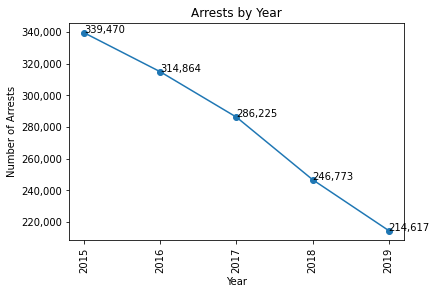

In [67]:
fig, ax = plt.subplots()
ax.plot(df_year.arrest_year, df_year.total_arrests, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Arrests")
ax.set_title("Arrests by Year")
plt.xticks([x for x in df_year.arrest_year])
plt.xticks(rotation = 90)

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

for i,j in zip(df_year.arrest_year, df_year.total_arrests):
    ax.annotate(format(j,','), xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)   

plt.show()

# ? How can I make this neater?

### Arrests by Year Percentage Change

In [68]:
df_year_pc = df.groupby('arrest_year', as_index=False)
df_year_pc = df_year_pc.size()
df_year_pc.rename(columns={'size':'total_arrests'}, inplace=True)
df_year_pc['change'] = round(df_year_pc.total_arrests.div(df_year_pc.total_arrests.shift(1))-1,2)
df_year_pc

,arrest_year,total_arrests,change
0,2015,339470,NaN
1,2016,314864,-0.07
2,2017,286225,-0.09
3,2018,246773,-0.14
4,2019,214617,-0.13


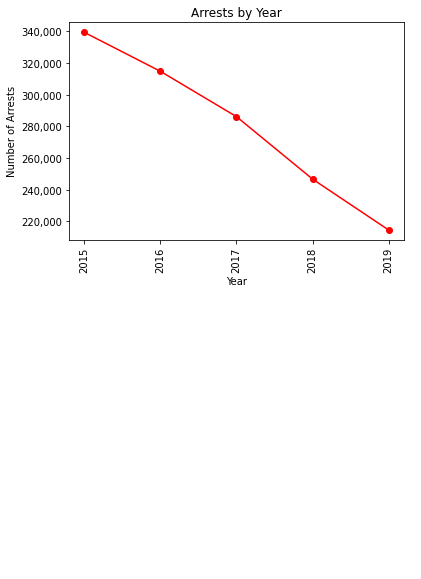

In [69]:
fig, ax = plt.subplots()
ax.plot(df_year_pc.arrest_year, df_year_pc.total_arrests, marker='o', color='red')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Arrests")
ax.set_title("Arrests by Year")
plt.xticks([x for x in df_year_pc.arrest_year])
plt.xticks(rotation = 90)

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

for i,j in zip(df_year_pc.arrest_year, df_year_pc.change):
    ax.annotate(j, xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)   

plt.show()

# ? Where are the labels?

### Drug Arrests by Year

In [70]:
df_drugs_year = df[df['category'] == 'DRUGS']
df_drugs_year = df_drugs_year.groupby('arrest_year', as_index=False)
df_drugs_year = df_drugs_year.size()
df_drugs_year.rename(columns={'size':'total_arrests'}, inplace=True)
df_drugs_year

,arrest_year,total_arrests
0,2015,55217
1,2016,52256
2,2017,48632
3,2018,32595
4,2019,21073


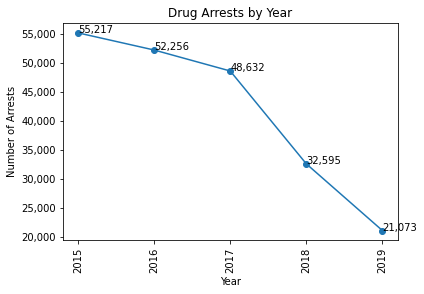

In [71]:
fig, ax = plt.subplots()
ax.plot(df_drugs_year.arrest_year, df_drugs_year.total_arrests, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Arrests")
ax.set_title("Drug Arrests by Year")
plt.xticks([x for x in df_drugs_year.arrest_year])
plt.xticks(rotation = 90)

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

for i,j in zip(df_drugs_year.arrest_year, df_drugs_year.total_arrests):
    ax.annotate(format(j, ','), xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)   

plt.show()

# ? Where are the labels?

### Arrests by Month and Year

In [72]:
df_year_month = df.groupby(['arrest_year','arrest_month'], as_index=False)
df_year_month = df_year_month.size()
df_year_month.rename(columns={'size':'total_arrests'}, inplace=True)
df_year_month.head()

,arrest_year,arrest_month,total_arrests
0,2015,1,25338
1,2015,2,27076
2,2015,3,30007
3,2015,4,29958
4,2015,5,28643


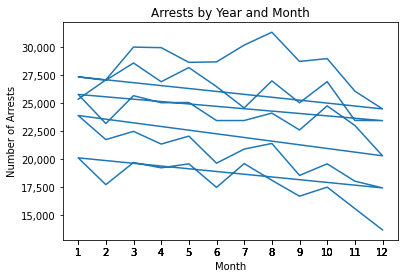

In [78]:
fig, ax = plt.subplots()
ax.plot(df_year_month.arrest_month, df_year_month.total_arrests)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Arrests")
ax.set_title("Arrests by Year and Month")
plt.xticks([x for x in df_year_month.arrest_month])

#for i,j in df_arrests_year.items():
#    ax.annotate(j, xy=(i,j))

#for i,j in zip(df_year_month.arrest_year, df_year_month.total_arrests):
#    ax.annotate(format(j, ','), xy=(i,j))

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

# plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

plt.show()

# ? Add colors for each line?

### Arrests by Month

In [76]:
df_month = df.groupby('arrest_month', as_index=False)
df_month = df_month.size()
df_month.rename(columns={'size':'total_arrests'}, inplace=True)
df_month.head()

,arrest_month,total_arrests
0,1,122424
1,2,116693
2,3,126382
3,4,122415
4,5,123456


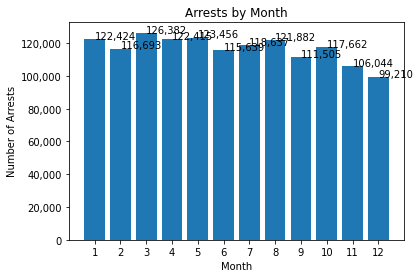

In [79]:
fig, ax = plt.subplots()
ax.bar(df_month.arrest_month, df_month.total_arrests)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Arrests')
ax.set_title('Arrests by Month')
plt.xticks([x for x in df_month.arrest_month])

ax.yaxis.set_major_formatter(
ticker.FuncFormatter(lambda y,p: format(int(y), ','))
)

for i,j in zip(df_month.arrest_month, df_month.total_arrests):
    ax.annotate(format((j), ','), xy=(i,j))

plt.show()